In [1]:
from shapely import geometry
from pulp import *
import pandas as pd
import geopandas as gpd
import numpy as np
from geopy.distance import geodesic
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import json
from area import area
import pickle

from vincenty import *
from shapely.strtree import STRtree

import networkx as nx

/home/lucas/miniconda3/envs/sips/lib/python3.7/site-packages/geopandas/_compat.py:78: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [19]:
ne = gpd.read_file('./../../../data/ne_10m_countries.gpkg')

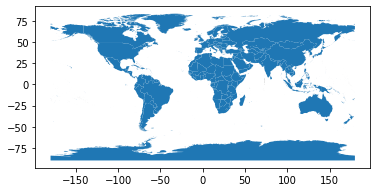

In [21]:
ne.plot()

In [23]:
mp = ne.unary_union

In [27]:
len(mp)

4049

In [25]:
import pickle

In [26]:
pickle.dump(mp,open('./../../../data/world_mp.pkl','wb'))

In [ ]:
pulp.pulpTestAll()

In [21]:
dist = np.arange(0,10,0.1)
mw = np.array([ii/10 for ii in range(10,0,-1)] + [ii/10 for ii in range(11)])

In [22]:
mw

array([1. , 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0. , 0.1, 0.2,
       0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [9]:
dist2d = np.stack([dist]*mw.shape[0])
mw2d = np.stack([mw]*dist.shape[0])

In [13]:
Z = dist2d**2

In [15]:
mw2d

array([[0. , 0.1, 0.2, ..., 1.7, 1.8, 1.9],
       [0. , 0.1, 0.2, ..., 1.7, 1.8, 1.9],
       [0. , 0.1, 0.2, ..., 1.7, 1.8, 1.9],
       ...,
       [0. , 0.1, 0.2, ..., 1.7, 1.8, 1.9],
       [0. , 0.1, 0.2, ..., 1.7, 1.8, 1.9],
       [0. , 0.1, 0.2, ..., 1.7, 1.8, 1.9]])

In [16]:
alpha=0.5

In [ ]:
# case: B=1
E_mw = mw2d

## Toy Model

In [23]:
pts_A = np.random.rand(10*2).reshape(10,2)*10
pts_B = np.random.rand(3*2).reshape(3,2)*10

In [24]:
pts_A = [geometry.Point(pt[0],pt[1]) for pt in pts_A.tolist()]
pts_B = [geometry.Point(pt[0],pt[1]) for pt in pts_B.tolist()]

In [25]:
for ii_A,pt in enumerate(pts_A):
    pt.MW = np.random.rand(1)*5
    pt.name='A_'+str(ii_A)
for ii_B,pt in enumerate(pts_B):
    pt.MW = np.random.rand(1)*40
    pt.name='B_'+str(ii_B)

In [26]:
def milp_geodesic_network_satisficing(pts_A, pts_B, alpha,v=False):
    pts_A_dict = {pt.name:pt for pt in pts_A}
    pts_B_dict = {pt.name:pt for pt in pts_B}
    
    A_names = [pt.name for pt in pts_A]
    B_names = [pt.name for pt in pts_B]
    
    Z = {pt.name:{} for pt in pts_A}
    MW_A = {pt.name:pt.MW for pt in pts_A}
    MW_B = {pt.name:pt.MW for pt in pts_B}
    
    if v:
        print ('generating Z..')
    for pt_A in pts_A:
        for pt_B in pts_B:
            
            Z[pt_A.name][pt_B.name]=(geodesic([pt_A.y,pt_A.x], [pt_B.y,pt_B.x]).kilometers)**2
            
    sum_Z = sum([Z[A_name][B_name] for A_name in A_names for B_name in B_names])
    
    ### declare model
    model = LpProblem("Network Satisficing Problem",LpMinimize)
    
    ### Declare variables
    # B -> Bipartite Network
    B = LpVariable.dicts("Bipartite",(A_names,B_names),0,1,LpInteger)
    
    # abs_diffs -> absolute value forcing variable
    abs_diffs = LpVariable.dicts("abs_diffs",B_names,cat='Continuous')
    
    ### Declare constraints
    # Contstraint - abs diffs edges
    for B_name in B_names:
        model += abs_diffs[B_name] >= (MW_B[B_name] - lpSum([MW_A[A_name]*B[A_name][B_name] for A_name in A_names]))/MW_B[B_name],"abs forcing pos {}".format(B_name) 
        model += abs_diffs[B_name] >= -1 * (MW_B[B_name] - lpSum([MW_A[A_name]*B[A_name][B_name] for A_name in A_names]))/MW_B[B_name], "abs forcing neg {}".format(B_name)
        
    # Constraint - bipartite edges
    for A_name in A_names:
        model += lpSum([B[A_name][B_name] for B_name in B_names]) <= 1,"Bipartite Edges {}".format(A_name)
        
    ### Affine equations
    # Impedence error
    E_z = sum([Z[A_name][B_name]*B[A_name][B_name] for A_name in A_names for B_name in B_names])/sum_Z
    
    # mw error
    E_mw = sum([abs_diffs[B_name] for B_name in B_names])/len(B_names)
    
    ### Objective function
    model += E_z*alpha + (1-alpha)*E_mw, "Loss"
    if v:
        print ('solving model...')
    
    model.solve(pulp.GUROBI_CMD())
    if v:
        print(pulp.LpStatus[model.status])
    
    return model, B, E_z, E_mw, Z

In [27]:
model, B, E_z, E_mw, Z = milp_geodesic_network_satisficing(pts_A, pts_B, 0.5, v=True)

generating Z..
solving model...
Optimal


In [28]:
pts_A_dict = {pt.name:pt for pt in pts_A}
pts_B_dict = {pt.name:pt for pt in pts_B}

In [29]:
E_z.value()

0.1226347562900856

In [30]:
for e in E_mw:
    print (e.name, e.value())

abs_diffs_B_0 0.99071771182126
abs_diffs_B_1 0.47369939933999994
abs_diffs_B_2 0.039891180645000024


In [36]:
for kk, vv in B.items():
    for kk2, vv2 in vv.items():
        print (kk,kk2,vv2.value())

A_0 B_0 0.0
A_0 B_1 0.0
A_0 B_2 1.0
A_1 B_0 0.0
A_1 B_1 0.0
A_1 B_2 1.0
A_2 B_0 0.0
A_2 B_1 0.0
A_2 B_2 1.0
A_3 B_0 0.0
A_3 B_1 0.0
A_3 B_2 0.0
A_4 B_0 0.0
A_4 B_1 1.0
A_4 B_2 0.0
A_5 B_0 0.0
A_5 B_1 1.0
A_5 B_2 0.0
A_6 B_0 1.0
A_6 B_1 0.0
A_6 B_2 0.0
A_7 B_0 0.0
A_7 B_1 1.0
A_7 B_2 0.0
A_8 B_0 0.0
A_8 B_1 1.0
A_8 B_2 0.0
A_9 B_0 0.0
A_9 B_1 1.0
A_9 B_2 0.0


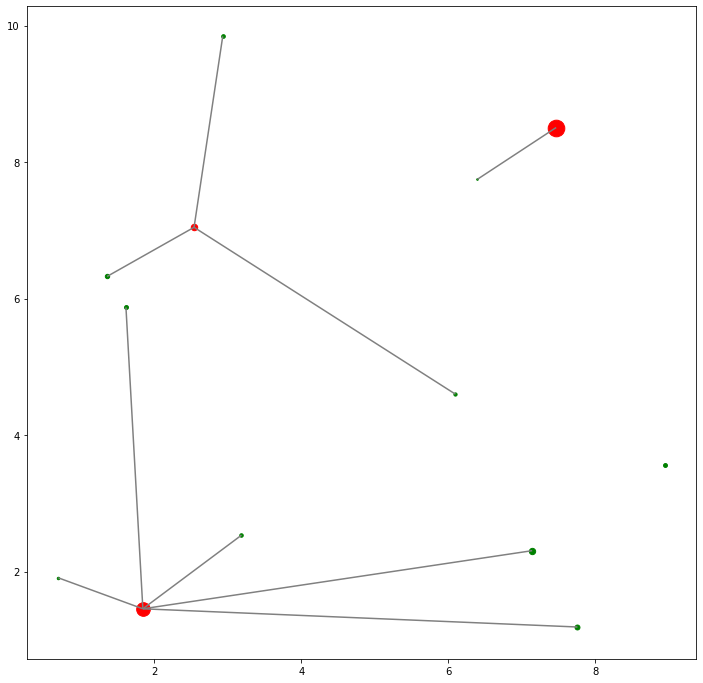

In [35]:
### visualise
fig, axs = plt.subplots(1,1,figsize=(12,12))
for pt in pts_A:
    axs.scatter(pt.x, pt.y, s=pt.MW*10,c='g')
for pt in pts_B:
    axs.scatter(pt.x,pt.y,s=pt.MW*10,c='r')
    
lines = []

for k1, v in B.items():
    for k2,v2 in v.items():
        if v2.varValue>0:
            lines.append([[pts_A_dict[k1].x,pts_A_dict[k1].y],[pts_B_dict[k2].x,pts_B_dict[k2].y]])

lc = LineCollection(lines, color='grey')

axs.add_collection(lc)



plt.show()

## To data

### wrangle data

In [ ]:
fts = json.load(open('./results_fcs_v1.3/ABCD_simplified.geojson','r'))

In [ ]:
GB = json.load(open('GB_v1.3.geojson','r'))
wri = pd.read_csv('global_power_plant_database.csv')
ws = pd.read_csv('wri_mixin.csv')

In [ ]:
GB_pts = []
for ii_f,ft in enumerate(GB['features']):
    poly = geometry.shape(ft['geometry'])
    pp = poly.representative_point()
    pp.MW = area(geometry.mapping(poly))*54/1000/1000
    if ft['properties']['SPOT_ids_0']=='':
        pp.name=str(ii_f)+'_'+str(ft['properties']['S2_ids_0'])
    else:
        pp.name=str(ii_f)+'_'+str(ft['properties']['SPOT_ids_0'])
    GB_pts.append(pp)
    

In [ ]:
wri.fuel1.unique()

In [ ]:
wri_records = wri[(wri.country=='GBR')&(wri.fuel1=='Solar')][['capacity_mw', 'name','latitude','longitude']].to_dict('records')

In [ ]:
for ii_r,r in enumerate(wri_records):
    r['MW'] = r['capacity_mw']
    r['pt'] = geometry.Point(r['longitude'],r['latitude'])
    r['name'] = str(ii_r)+'_'+str(r['name'])

In [ ]:
ws_records = ws[ws.iso2=='GB'][['WS Coords','MW','WS Name']].to_dict('records')

In [ ]:
for r in ws_records:
    r['WS Coords'] = r['WS Coords'].replace(' E','')
    r['pt'] = geometry.Point(float(r['WS Coords'].split(',')[-1]),float(r['WS Coords'].split(',')[0]))
    r['name'] = r['WS Name']

In [ ]:
records = wri_records + ws_records

In [ ]:
country_shps = json.load(open('/home/lucaskruitwagen/DPHIL/DPHIL_CLASSIFICATION/Solar_PV/NE/ne_10m_admin_0_countries.geojson','r'))
GB_shp = [ft for ft in country_shps['features'] if ft['properties']['ISO_A2']=='GB']

In [ ]:
R_pts = []
for r in records:
    pp = r['pt']
    pp.MW =r['MW']
    pp.name=r['name']
    R_pts.append(pp)

### Get components with threshold

In [ ]:
def get_matches_treenx(A_polys,P_polys):
    ### return a list of matches. both polys need a property which is primary_id
    
    P_tree = STRtree(P_polys)
    G = nx.Graph()
    
    for pp_A in A_polys:
        t_result = P_tree.query(pp_A)
        t_result = [pp for pp in t_result if pp.intersects(pp_A)]
        if len(t_result)>0:
            for r in t_result:
                G.add_edge(pp_A.name,r.name)
                
    return list(nx.connected_components(G))

In [ ]:
buffer_dist = 1500 #m

In [ ]:
GB_polys = []
for pt in GB_pts:
    pp = pt.buffer(V_dir([pt.y,pt.x],buffer_dist,0)[0][0]-pt.y)
    pp.name = pt.name
    GB_polys.append(pp)
    
R_polys = []
for pt in R_pts:
    pp = pt.buffer(V_dir([pt.y,pt.x],buffer_dist,0)[0][0]-pt.y)
    pp.name = pt.name
    R_polys.append(pp)

In [ ]:
components = get_matches_treenx(GB_polys,R_polys)


In [ ]:
len(components)

In [ ]:
### visualise components
fig, axs = plt.subplots(1,1,figsize=(16,16))
for shp_ft in GB_shp[1:2]:
    geom = geometry.shape(shp_ft['geometry'])
    if geom.type=='Polygon':
        xs,ys = geom.exterior.xy
        axs.plot(xs,ys,c='grey')
    if geom.type=='MultiPolygon':
        for subgeom in geom:
            xs,ys = subgeom.exterior.xy
            axs.plot(xs,ys,c='grey')

for c in components:
    pts = [pt for pt in GB_pts if pt.name in c]
    pts += [pt for pt in R_pts if pt.name in c]
    rnd_col = np.random.rand(3,)
    axs.scatter([pt.x for pt in pts], [pt.y for pt in pts],c=[rnd_col]*len(pts))

plt.show()
                

In [ ]:
alpha = 0.15

In [ ]:
B_dict = {}

In [ ]:
E_z_all = 0
E_mw_all = 0

for ii_c, component in enumerate(components):
    if ii_c % 100==0:
        print (ii_c)
    pts_A = [pt for pt in GB_pts if pt.name in component]
    pts_B = [pt for pt in R_pts if pt.name in component]
    #print (len(pts_A),len(pts_B))
    model, B, E_z, E_mw, Z = milp_geodesic_network_satisficing(pts_A, pts_B, alpha)
    E_z_all += E_z.value()
    E_mw_all += E_mw.value()
    B_dict[ii_c] = B
    #print (Z)
    #for k1, v in B.items():
    #    for k2,v2 in v.items():
    #        if v2.varValue>0:
    #            print (k1,k2,v2,11)
print ('E_z', E_z_all, 'E_mw',E_mw_all)

In [ ]:
### visualise results
fig, axs = plt.subplots(1,1,figsize=(72,72))
for shp_ft in GB_shp[1:2]:
    geom = geometry.shape(shp_ft['geometry'])
    if geom.type=='Polygon':
        xs,ys = geom.exterior.xy
        axs.plot(xs,ys,c='grey')
    if geom.type=='MultiPolygon':
        for subgeom in geom:
            xs,ys = subgeom.exterior.xy
            axs.plot(xs,ys,c='grey')
            
            
### cyan and purple - unmatched outside of components
            
for ii_c, component in enumerate(components):

    pts_A = [pt for pt in GB_pts if pt.name in component]
    pts_B = [pt for pt in R_pts if pt.name in component]
    pts_A_dict = {pt.name:pt for pt in pts_A}
    pts_B_dict = {pt.name:pt for pt in pts_B}
    
    
    lines = []
    pts_recs = []
    pts_obs = []
    done_As = []
    done_Bs = []
    #print (B_dict[ii_c])

    for k1, v in B_dict[ii_c].items():
        #k1 - cluster
        for k2,v2 in v.items():
            #k2 - 
            #print (k1,k2,v2, v2.varValue)
            if v2.varValue>0:
                #matches observations
                pts_obs.append([pts_A_dict[k1].x,pts_A_dict[k1].y,pts_A_dict[k1].MW])
                done_As.append(k1)
                
                #mathes dataset
                pts_recs.append([pts_B_dict[k2].x,pts_B_dict[k2].y,pts_B_dict[k2].MW])
                done_Bs.append(k2)
                
                #match lines
                lines.append([[pts_A_dict[k1].x,pts_A_dict[k1].y],[pts_B_dict[k2].x,pts_B_dict[k2].y]])
    #print (ii_c,len(component),len(pts_A),len(pts_B),len(lines))
    lc = LineCollection(lines, color='grey')
    
    ### pink and green for matched
    axs.scatter([pt[0] for pt in pts_obs],[pt[1] for pt in pts_obs],s=[pt[2] for pt in pts_obs],c='green')
        

    axs.scatter([pt[0] for pt in pts_recs],[pt[1] for pt in pts_recs],s=[pt[2] for pt in pts_recs],c='pink')
    
    for name,pt in pts_A_dict.items():
        if name not in done_As:
            axs.scatter(pt.x,pt.y,s=pt.MW,c='b')
        
    for name,pt in pts_B_dict.items():
        if name not in done_Bs:
            axs.scatter(pt.x,pt.y,s=pt.MW,c='r')

    axs.add_collection(lc)
    
axs.set_xlim([-6,-4])
axs.set_ylim([49,51])



plt.show()

### get impedence network

In [ ]:
pts_R_dict = {pt.name:pt for pt in R_pts}
pts_GB_dict = {pt.name:pt for pt in GB_pts}

In [ ]:
R_names = [pt.name for pt in R_pts]
GB_names = [pt.name for pt in GB_pts]

In [ ]:
Z = {pt.name:{} for pt in GB_pts}
MW_GB = {pt.name:pt.MW for pt in GB_pts}
MW_R = {pt.name:pt.MW for pt in R_pts}

In [ ]:
len(GB_pts), len(R_pts)

In [ ]:
for ii_A,pt_A in enumerate(GB_pts):
    if ii_A % 100 ==0:
            print ('ii_A',ii_A)
    for pt_B in R_pts:
        
        #print (pt_A.name, pt_B.name)
        Z[pt_A.name][pt_B.name]=geodesic([pt_A.x,pt_A.y], [pt_B.x,pt_B.y]).kilometers

In [ ]:
pickle.dump(Z,open('Z.pickle','wb'))

In [ ]:
Z= pickle.load(open('Z.pickle','rb'))

### Set up problem

#### Define problem

In [ ]:
model = LpProblem("Network Satisficing Problem",LpMinimize)

#### Define Variables

In [ ]:
# B -> bipartite 
B = LpVariable.dicts("Bipartite",(GB_names,R_names),0,1,LpInteger)

In [ ]:
# Differences between MW and MW in (needs variable to ensure absolute value)
abs_diffs = LpVariable.dicts("abs_diffs",R_names,cat='Continuous')

#### Define Constraints

In [ ]:
# Contstraint - abs diffs edges
for R_name in R_names:
    model += abs_diffs[R_name] >= (MW_R[R_name] - lpSum([MW_GB[GB_name]*B[GB_name][R_name] for GB_name in GB_names]))/MW_R[R_name],"abs forcing pos {}".format(R_name) 
    model += abs_diffs[R_name] >= -1 * (MW_R[R_name] - lpSum([MW_GB[GB_name]*B[GB_name][R_name] for GB_name in GB_names]))/MW_R[R_name], "abs forcing neg {}".format(R_name)

In [ ]:
# Contstraint - bipartite edges
for GB_name in GB_names:
    model += lpSum([B[GB_name][R_name] for R_name in R_names]) <= 1,"Bipartite Edges {}".format(GB_name) 

#### Define constants and affine equations

In [ ]:
alpha = 0.5

In [ ]:
sum_Z = sum([Z[GB_name][R_name] for GB_name in GB_names for R_name in R_names])

In [ ]:
E_z = sum([Z[GB_name][R_name]*B[GB_name][R_name] for GB_name in GB_names for R_name in R_names])/sum_Z

In [ ]:
E_mw = sum([abs_diffs[R_name] for R_name in R_names])/len(R_names)

#### Defin Objective Function

In [ ]:
# Objective function
model += E_z*alpha + (1-alpha)*E_mw, "Loss"

In [ ]:
model.solve()
pulp.LpStatus[model.status]

In [ ]:
E_z.value()

In [ ]:
for e in E_mw:
    print (e.name, e.value())

In [ ]:
### visualise
fig, axs = plt.subplots(1,1,figsize=(12,12))
for pt in pts_A:
    axs.scatter(pt.x, pt.y, s=pt.MW*10,c='g')
for pt in pts_B:
    axs.scatter(pt.x,pt.y,s=pt.MW*10,c='r')
    
lines = []

for k1, v in B.items():
    for k2,v2 in v.items():
        if v2.varValue>0:
            lines.append([[pts_A_dict[k1].x,pts_A_dict[k1].y],[pts_B_dict[k2].x,pts_B_dict[k2].y]])

lc = LineCollection(lines, color='grey')

axs.add_collection(lc)



plt.show()

## Demo

In [ ]:
model = LpProblem("Profit maximising problem", pulp.LpMaximize)

In [ ]:
A = LpVariable('A', lowBound=0, cat='Integer')
B = LpVariable('B', lowBound=0, cat='Integer')

In [ ]:
profit = 3000 * A + 45000 * B

In [ ]:
# Objective function
model += profit, "Profit"

# Constraints
model += 3 * A + 4 * B <= 30
model += 5 * A + 6 * B <= 60
model += 1.5 * A + 3 * B <= 21

In [ ]:
model.solve()
pulp.LpStatus[model.status]

In [ ]:
print ("Production of Car A = {}".format(A.varValue))
print ("Production of Car B = {}".format(B.varValue))

## Archive

In [ ]:
E_z_1 = LpVariable.dicts('E_z_1', (A_names,B_names),lowBound=0, cat='Continuous')

In [ ]:
E_z_0 = LpVariable.dicts('E_z_0',A_names, lowBound=0, cat='Continuous')

In [ ]:
E_z_t = LpVariable('E_z_t',lowBound = 0, cat='Continuous')

In [ ]:
for A_name in A_names:
    for B_name in B_names:
        model+= E_z_1 == bipartite[A_name][B_name] * Z[A_name][B_name]

In [ ]:
for A_name in A_names:
    model += E_z_0[A_name] == lpSum([E_z_1[A_name][B_name] for B_name in B_names])